In [11]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import read_geolife
import tracers as tr
import matplotlib.pyplot as plt
from pyproj import Transformer
import math
import seaborn as sns
import os

In [16]:
traces = []
processed_traces = []  

root_path = "/mnt/d/romataxi"

for i in range(375):
    user_path = f'{i}.csv'
    file_path = os.path.join(root_path, user_path)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=",")
        traces.append(df) 

for trace_df in traces:
    # Convert timestamp to epoch, with invalid timestamps set to NaT
    trace_df["Timestamp"] = pd.to_datetime(trace_df["Timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9

    # Drop rows where Timestamp is NaT (invalid timestamps)
    trace_df = trace_df.dropna(subset=["Timestamp"])

    # Sort by time
    trace_df = trace_df.sort_values(by='Timestamp')

    # Convert to array (Longitude, Latitude, Timestamp)
    trace = trace_df[['Longitude', 'Latitude', 'Timestamp']].to_numpy()

    #take only the first 5000 points
    trace = trace[:500]

    # Convert to list of tuples
    trace = [tuple(x) for x in trace]
    trace = [(x[0], x[1], int(x[2])) for x in trace]
    processed_traces.append(trace)

traces = processed_traces
print(f"Number of traces: {len(traces)}")

Number of traces: 316


In [17]:
(space_noise, time_min_period) = (70.0, 30)
#Picker string 'closest' 
perturbed_traces = tr.perturb_traces((space_noise, time_min_period), traces, picker_str='closest')

In [5]:
lat_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9028, 12.4965)) * 10000
lon_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9029, 12.4964)) * 10000
print("50 meter lat is: ", 10/lat_meter_per_degree, "°")
print("50 meter lon is: ", 10/lon_meter_per_degree, "°")
meter_per_degree = (lat_meter_per_degree + lon_meter_per_degree)/2
print(75/meter_per_degree)

50 meter lat is:  9.039443250896991e-05 °
50 meter lon is:  9.199689221384284e-05 °
0.0006839146716734492


In [18]:
from scipy import stats
lat_noise = []
lon_noise = []
angles = []
noise_distr = []

wgs84_to_utm = Transformer.from_crs(4326, 3065, always_xy=True)

for trace_idx in range(len(traces)):
    for point_idx in range(len(traces[trace_idx])):

        perturbed_traces_lon,perturbed_traces_lat = perturbed_traces[trace_idx][point_idx][0], perturbed_traces[trace_idx][point_idx][1]
        traces_lon,traces_lat = traces[trace_idx][point_idx][0], traces[trace_idx][point_idx][1]
        
        noise = tr.rs_geodesic_distance((perturbed_traces_lon,perturbed_traces_lat),(traces_lon,traces_lat))
        noise_distr.append(noise/meter_per_degree)

/home/dieter/thesis/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


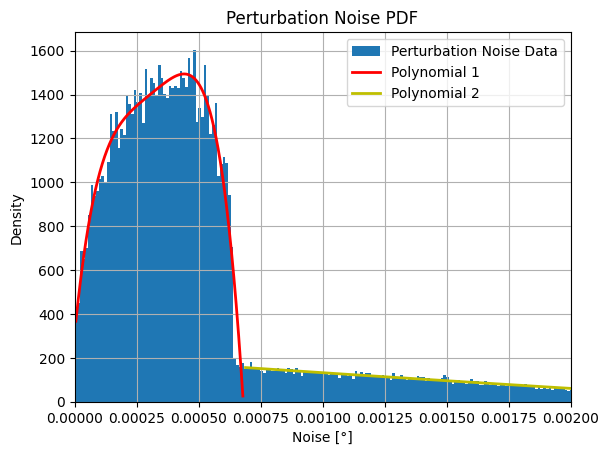

            4             3             2
-2.894e+14 x + 3.557e+11 x - 1.647e+08 x + 3.705e+04 x + 1
           2
1.011e+04 x - 263.4 x + 0.6846
306.47666533454407


In [19]:
hist_values, bin_edges = np.histogram(noise_distr, bins=20000, density=True)  

# Compute bin centers (since polyfit needs x values)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
# Define polynomial fitting ranges
range1 = (bin_centers > 0) & (bin_centers < 0.000684)
range2 = (bin_centers > 0.000684) & (bin_centers < 0.0025)

x1, y1 = bin_centers[range1], hist_values[range1]
x2, y2 = bin_centers[range2], hist_values[range2]

coeffs_1 = np.polyfit(x1, y1, 4)
f_1 = np.poly1d(coeffs_1)
x_smooth_1 = np.linspace(min(x1), max(x1), 1000)
max_value = np.max(f_1(range1))
y_smooth_1 = f_1(x_smooth_1)

coeffs_2 = np.polyfit(x2, y2, 2)
f_2 = np.poly1d(coeffs_2)
x_smooth_2 = np.linspace(min(x2), max(x2), 1000)
y_smooth_2 = f_2(x_smooth_2)

plt.hist(noise_distr, bins=20000, density=True, label="Perturbation Noise Data")
plt.plot(x_smooth_1, y_smooth_1, 'r-', linewidth=2, label=f"Polynomial 1")
plt.plot(x_smooth_2, y_smooth_2, 'y-', linewidth=2, label=f"Polynomial 2")
plt.legend()
plt.xlabel("Noise [°]")
plt.ylabel("Density")
plt.title("Perturbation Noise PDF")
plt.xlim(0, 0.002)
plt.grid(True)
plt.show()

print(f_1/max_value)
print(f_2/max_value)
print(max_value)

### Noise angle

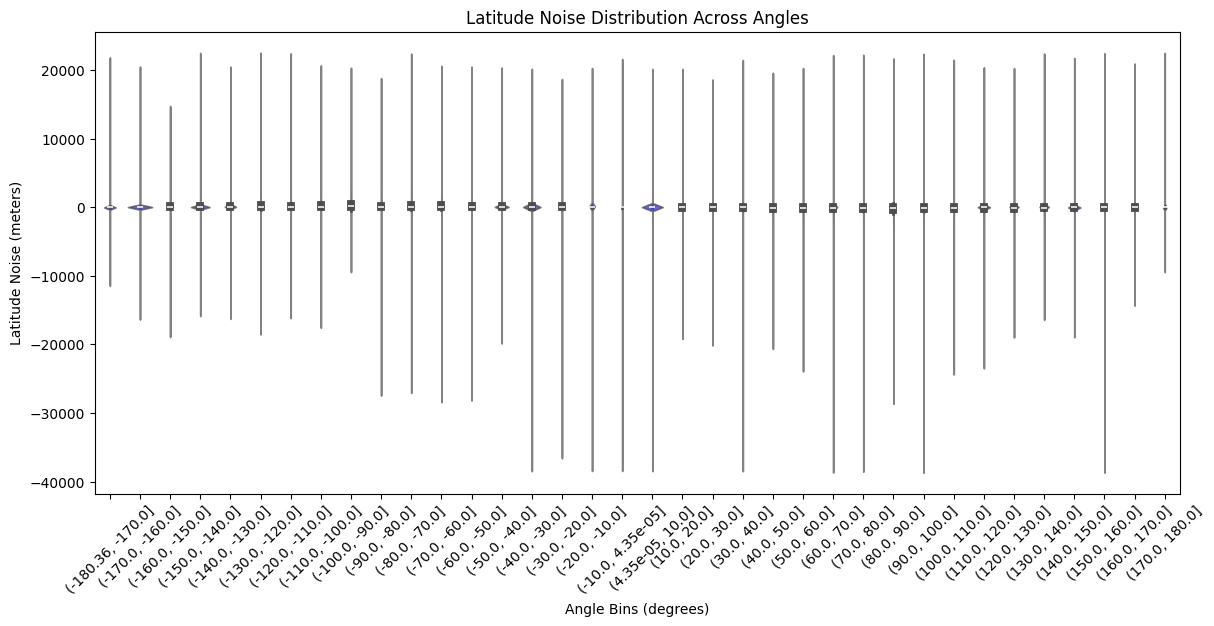

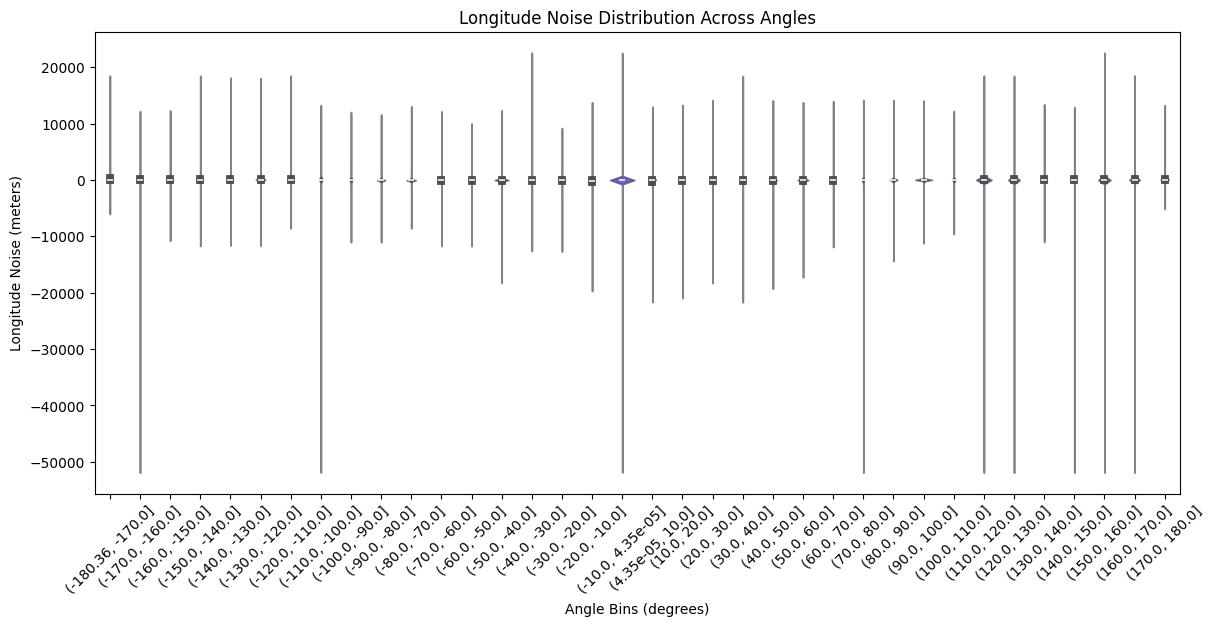

In [19]:
angles_deg = np.degrees(angles)

# Violin plot to show distribution
plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lat_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Latitude Noise (meters)")
plt.title("Latitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lon_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Longitude Noise (meters)")
plt.title("Longitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()


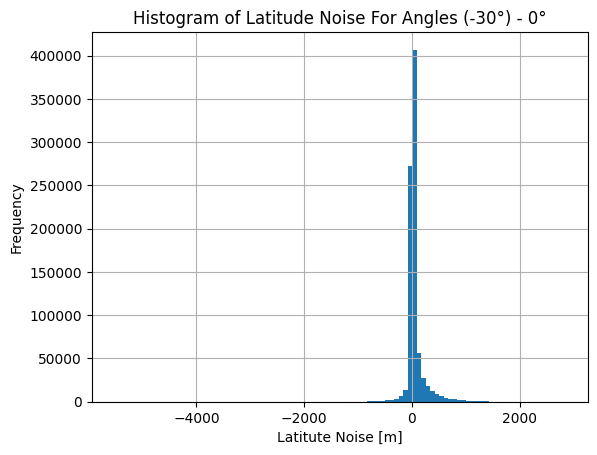

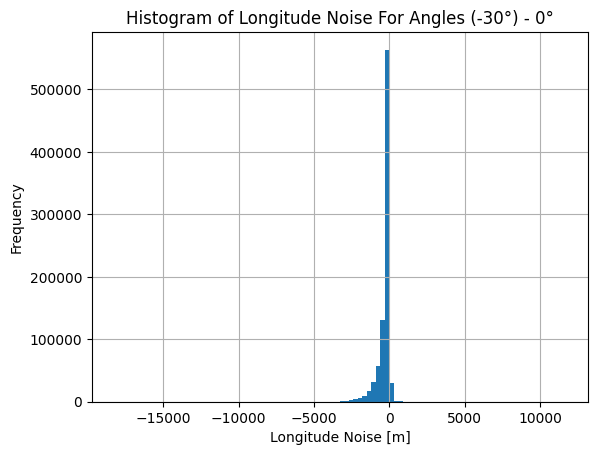

In [ ]:
#angle range
angle_min = -30
angle_max = 0

selected_indices = (angles_deg >= angle_min) & (angles_deg < angle_max)
selected_lon_noise = np.array(lon_noise)[selected_indices]
selected_lat_noise = np.array(lat_noise)[selected_indices]

plt.hist(selected_lat_noise, bins=100)
plt.xlabel("Latitute Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Latitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()

plt.hist(selected_lon_noise, bins=100)
plt.xlabel("Longitude Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Longitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()
